In [1]:
from preprocess import tseries
from model import model
from postprocess import forecast

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
plt.style.use('seaborn-notebook')

In [4]:
# Pull in data: monthly sum of bikes going northbound on Fremont Avenue Bridge.
dataset = (
    pd.read_csv('https://data.seattle.gov/resource/4xy5-26gy.csv', parse_dates=True, index_col='date')
        .resample('1M')
        .sum()
)
dataset = dataset.loc[(dataset.index >= '2013-01-31') & (dataset.index <= '2016-12-31')]
y = np.array(dataset['fremont_bridge_nb'])
index = np.array(dataset.index)

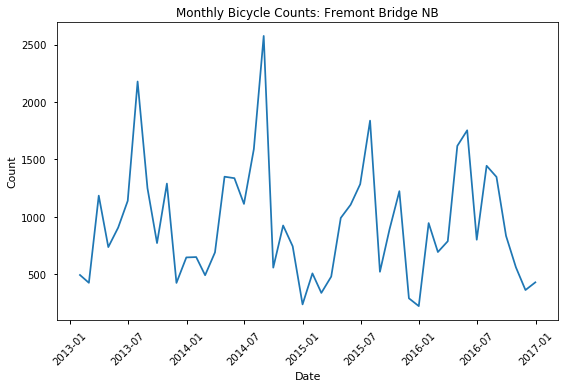

In [5]:
# Make a tseries object and plot it. Monthly data, so try setting the season to 12.
data = tseries(y=y, date=index, season=12)
plt.show(data.plot_series_transformed(title='Monthly Bicycle Counts: Fremont Bridge NB', y_lab='Count', x_lab='Date'))

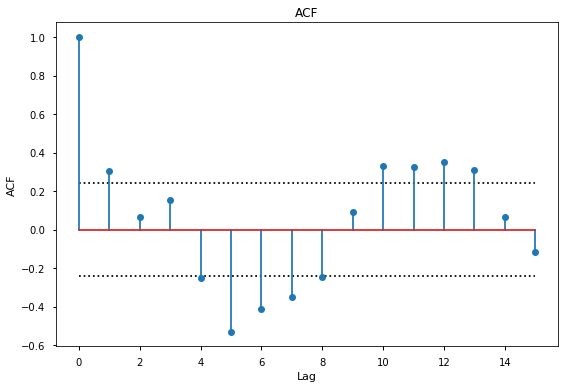

In [6]:
# Plot the series ACF.
plt.show(data.plot_acf())

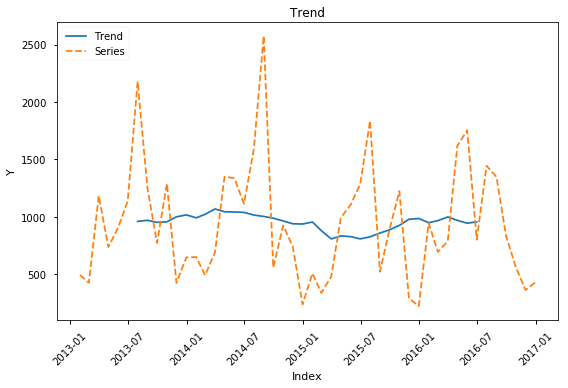

In [7]:
# Plot trend and overlay the original series.
plt.show(data.plot_trend(overlay=True))

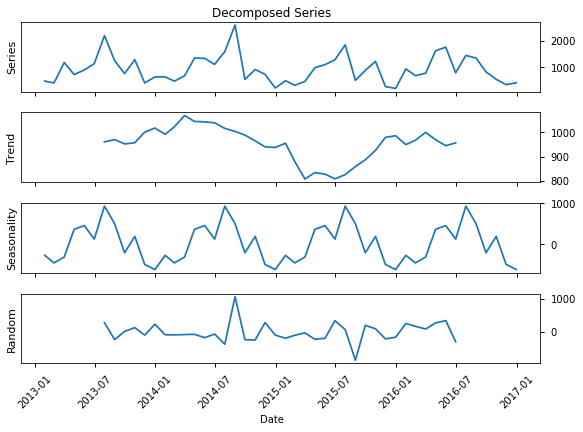

In [8]:
# Plot the series decomposition.
plt.show(data.plot_series_decomposition(x_lab='Date'))

In [9]:
# Forecast next year using a seasonal naive model. Calculate standard errors using bootstrapped residuals.
forecast = model.naive_model(data, h=12, bootstrap=True, n_samples=5000, seasonal=True)

In [10]:
# Show point predictions for next year.
forecast.y_point

array([[ 946.],
       [ 694.],
       [ 788.],
       [1618.],
       [1754.],
       [ 801.],
       [1445.],
       [1348.],
       [ 835.],
       [ 561.],
       [ 363.],
       [ 430.]])

In [11]:
# Get the mean of the point predictions.
forecast.y_point.mean()

965.25

In [12]:
# What confidence level did we use...
forecast.model_info['level']

array([0.95])

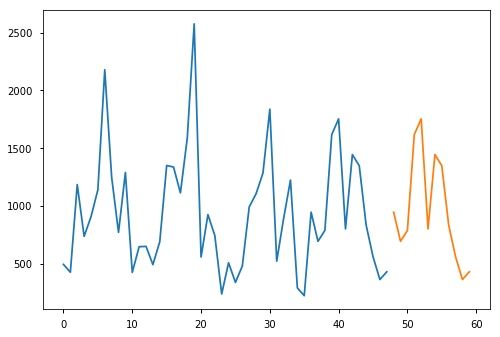

In [13]:
# Plot original series along with forecasted values.
plt.plot(np.arange(len(forecast.y_original)), forecast.y_original)
plt.plot(np.arange(len(forecast.y_original), 60, 1), forecast.y_point)
plt.show()

In [14]:
# Take data through 2015 as training data.
y_train = tseries(y=y[:-12], date=index)
y_train.y_transformed

array([ 494.,  426., 1185.,  737.,  907., 1140., 2179., 1250.,  772.,
       1290.,  425.,  647.,  650.,  492.,  691., 1350., 1337., 1113.,
       1590., 2576.,  558.,  925.,  744.,  238.,  508.,  338.,  480.,
        991., 1106., 1285., 1838.,  522.,  890., 1224.,  291.,  223.])

In [15]:
# Set aside the 2016 observations as ground truth.
y_true = y[-12:]

In [16]:
# Predict 2016 with a drift model. Obviously this is not the correct model, but whatevs...
forecast = model.drift_model(y_train, h=len(y_true), bootstrap=True, n_samples=5000)
forecast.y_point

array([[215.25714286],
       [207.51428571],
       [199.77142857],
       [192.02857143],
       [184.28571429],
       [176.54285714],
       [168.8       ],
       [161.05714286],
       [153.31428571],
       [145.57142857],
       [137.82857143],
       [130.08571429]])

In [17]:
# Get RMSE and MAE by comparing predictions to ground truth.
forecast.accuracy(y_true, ['RMSE', 'MAE'])

array([[909.83207541],
       [792.57857143]])

In [18]:
# Alternatively...
model.drift_model(y_train, h=len(y_true), bootstrap=True, n_samples=5000).accuracy(y_true, ['RMSE', 'MAE'])

array([[909.83207541],
       [792.57857143]])

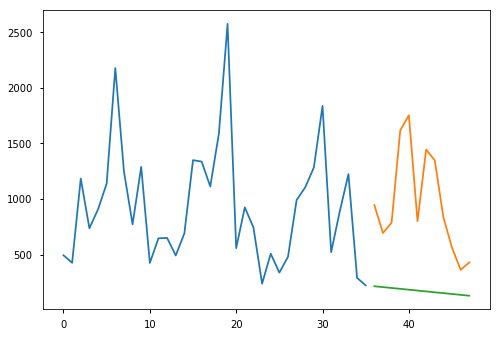

In [19]:
# Plot point y_train, y_true, y_point.
y_train_len = len(y_train.y_transformed)
y_true_len = len(y_true)
stacked_results = np.hstack((forecast.y_lb, forecast.y_point, forecast.y_ub))
plt.plot(np.arange(0, y_train_len, 1), forecast.y_original)
plt.plot(np.arange(y_train_len, y_train_len + y_true_len, 1), y_true)
plt.plot(np.arange(y_train_len, y_train_len + y_true_len, 1), stacked_results[:, 1])
plt.show()